# A Symbolic Interpreter and Correctness of Symbolic Transitions

Executing a program with the concrete minipy interpreter updates the passed environment, and potentially raises an exception. Symbolic execution, in contrast, takes into account all feasible paths through a program. We distinguish between *online* and *offline* SE (see, e.g., {cite}`baldoni.coppa.ea-18`). Online SE executes multiple symbolic paths simultaneously: For example, executing an `if` statement leads to two paths which are both explored. Offline SE reasons about one single path at a time. *Concolic execution*, where SE is guided by a single *concrete* input, is an example of the latter class. In this section, we regard *online* SE. Symbolically executing a program in an online symbolic interpreter results in multiple output environments. Also, such an interpreter cannot simply raise an exception, as this would result in a premature termination of the analysis, skipping other feasible program paths. The consequences for our static, online symbolic interpreter are:

* Instead of updating the initial symbolic environment, the interpreter produces potentially multiple new environments. Our interpreter even outputs all *intermediate* states, such that the output is a *Symbolic Execution Tree* (SET).
* Thrown exceptions are stored in the symbolic environment instead of being raise. Thus, we need another field in our `SymbolicEnvironment` class.

We first update the implementation of `SymbolicEnvironment` to include abrupt completion information:

In [1]:
import utils
from minipy import *
from semantics import *

In [12]:
class SymbolicEnvironment(SymbolicEnvironment):
    def __init__(self,
                 store: Optional[SymbolicStore] = None,
                 path_constraints: Optional[Set[z3.BoolRef]] = None,
                 abrupt_completion: Optional[Exception] = None,
                 functions: Optional[Dict[str, Tuple[Tuple[Variable], Type, Callable]]] = None):
        super().__init__(store, path_constraints, functions)
        self.abrupt_completion = abrupt_completion

    def copy(self):
        return SymbolicEnvironment(self.store, self.path_constraints, self.abrupt_completion, self.functions)

    def set(self, variable: Variable, value: SymbolicValueType) -> 'SymbolicEnvironment':
        return SymbolicEnvironment(self.store.set(variable, value), self.path_constraints,
                                   self.abrupt_completion, self.functions)

    def set_abrupt_completion(self, exc: Optional[Exception]) -> 'SymbolicEnvironment':
        return SymbolicEnvironment(self.store, self.path_constraints, exc, self.functions)

    def add_constraint(self, constraint: z3.BoolRef) -> 'SymbolicEnvironment':
        new_constraint = self.store.apply_to(constraint)
        old_constraints = {constraint for constraint in self.path_constraints
                           if not implies(new_constraint, constraint)}
        return SymbolicEnvironment(self.store,
                                   old_constraints | {new_constraint},
                                   self.abrupt_completion, self.functions)

    def add_function(self, name: str, params: Tuple[Variable], type: Type, impl: Callable) -> 'SymbolicEnvironment':
        new_functions = copy.deepcopy(self.functions)
        new_functions[name] = (params, type, impl)
        return SymbolicEnvironment(self.store, self.path_constraints, self.abrupt_completion, new_functions)

    def __str__(self):
        return ("(" +
                ("{}" if not self.path_constraints else str(self.path_constraints)) + ", " +
                str(self.store) +
                ("" if self.abrupt_completion is None else repr(self.abrupt_completion)) +
                ")")

    def to_html(self):
        prev_html = z3.in_html_mode()
        z3.set_html_mode(True)

        path_constraint_string = "{"
        if self.path_constraints:
            path_constraint_string += ", ".join(map(z3_html_escape, map(z3.obj_to_string, self.path_constraints)))
        path_constraint_string += "}"

        path_constraint_string = path_constraint_string.replace("\n", "<BR/>").replace(" ", "&nbsp;")

        result = f"({path_constraint_string}, "
        if self.abrupt_completion:
            result += f"{repr(self.abrupt_completion)}, "
        result += f"{self.store.to_html()})"

        z3.set_html_mode(prev_html)
        return result

    def __repr__(self):
        result = f"SymbolicEnvironment({repr(self.store)}, " \
                 f"{repr(self.path_constraints)}, " \
                 f"{repr(self.abrupt_completion)}, "
        result += repr({f_name: f"fun {f_name}{params} -> "
                                f"{type}" for f_name, (params, type, _) in self.functions.items()})
        return f"{result})"

    def __eq__(self, other):
        return isinstance(other, SymbolicEnvironment) and self.store == other.store and \
               self.path_constraints == other.path_constraints and \
               self.functions == other.functions and \
               (self.abrupt_completion == other.abrupt_completion is None or
                ExceptionWrapper(self.abrupt_completion) == ExceptionWrapper(other.abrupt_completion))


Next, we define a class for nodes in an SET. An SET node comprises a symbolic environment and a string representation of the next instruction to execute. We also define a `to_html` method to produce pretty output.

In [3]:
class SETNode:
    def __init__(self, environment: SymbolicEnvironment, pc: Optional[Union[ParseTree, str]] = None):
        self.environment = environment
        self.pc = pc

    @property
    def pc(self):
        return self.__pc

    @pc.setter
    def pc(self, pc: Optional[Union[ParseTree, str]]):
        if pc is None:
            self.__pc = ""
        elif type(pc) is str:
            self.__pc = pc
        else:
            assert type(pc) is tuple
            self.__pc = "" if pc is None else tree_to_string(pc).split("\n")[0].strip()

    def to_html(self):
        prev_html = z3.in_html_mode()
        z3.set_html_mode(True)

        result = f'<TABLE BORDER="0"><TR>'
        if "<BR/>" in self.environment.to_html():
            result += f'<TD BALIGN="LEFT" ALIGN="LEFT">{self.environment.to_html()}</TD>'
        else:
            result += f'<TD>{self.environment.to_html()}</TD>'
        result += "</TR>"

        if self.pc:
            result += '<TR><TD ALIGN="CENTER"><FONT FACE="Courier">' + z3_html_escape(self.pc) + "</FONT></TD></TR>"
        result += "</TABLE>"

        z3.set_html_mode(prev_html)
        return result

    def __repr__(self):
        return f"SETNode({repr(self.environment)}, {repr(self.pc)})"

    def __eq__(self, other):
        return type(other) is type(self) and self.environment == other.environment and self.pc == other.pc

Symbolic execution trees themselves are defined just like derivation trees, only with `SETNode`s instead of strings as nodes.

In [4]:
SET = Tuple[SETNode, List['SET']]

The following function produces graphical representations (using GraphViz) of SETs.

In [5]:
from graphviz import Digraph

In [6]:
def display_set(symbolic_execution_tree: SET) -> Digraph:
    def traverse_tree(dot: Digraph, tree: SET, node_id=0):
        node, children = tree
        dot.node(repr(node_id), "<" + node.to_html() + ">")

        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                dot.edge(repr(node_id), repr(child_id))
                traverse_tree(dot, child, child_id)

    counter = 0
    dot = Digraph(comment="Symbolic Execution Tree")
    dot.attr('node', shape='box')
    traverse_tree(dot, symbolic_execution_tree)
    return dot

Recall our small example from the previous section:

In [7]:
x = 0
y = 0

In [8]:
x = 2 * y
if x < 0:
    x = -x

The final SET resulting from symbolically executing this program will contain two leaves, one branch each for the case where the condition of the `if` statements hold or does not hold, respectively. Apart from the root, it also contains two inner nodes corresponding to the first assignment and the `if` statement. In the absence of an implemented symbolic interpreter, we manually construct this SET:

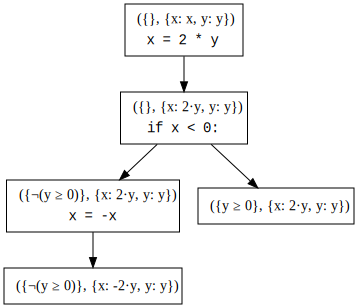

In [13]:
x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

env_0 = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), y: y.to_z3()}))
env_1 = env_0.set(x, z3.IntVal(2) * y.to_z3())
env_2 = env_1.add_constraint(x.to_z3() < z3.IntVal(0))
env_2_1 = env_2.set(x, z3.IntVal(-1) * x.to_z3())
env_3 = env_1.add_constraint(z3.Not(x.to_z3() < z3.IntVal(0)))

root = SETNode(env_0, "x = 2 * y")
if_node = SETNode(env_1, "if x < 0:")
inversion_node = SETNode(env_2, "x = -x")
leave_1 = SETNode(env_2_1)
leave_2 = SETNode(env_3)

tree = (root, [
    (if_node, [
        (inversion_node, [(leave_1, [])]),
        (leave_2, [])])])

display_set(tree)

## References

```{bibliography}
:filter: docname in docnames
```